# Identity Resolutotion - FM and TM

## 1. Setup

In [44]:
from PyDI.entitymatching.blocking import TokenBlocker
import logging
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from PyDI.entitymatching.blocking import StandardBlocker
from PyDI.entitymatching.evaluation import EntityMatchingEvaluator
from PyDI.entitymatching.blocking import NoBlocker, TokenBlocker
import time # Import time to measure runtime
from pathlib import Path
from PyDI.entitymatching.comparators import StringComparator, NumericComparator, DateComparator
from PyDI.entitymatching import RuleBasedMatcher
import matplotlib.pyplot as plt
import seaborn as sns
from PyDI.entitymatching import GreedyOneToOneMatchingAlgorithm, StableMatching, MaximumBipartiteMatching
import time
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from PyDI.entitymatching import FeatureExtractor, MLBasedMatcher

In [2]:

os.makedirs('logs/', exist_ok=True)

# choose either default logging or debug logging

# # Configure logging for INFO level
# logging.basicConfig(
#     level=logging.INFO,
#     format='[%(levelname)-5s] %(name)s - %(message)s',
#     handlers=[
#           logging.FileHandler('logs/pydi.log'),  # Save to file
#           logging.StreamHandler()                      # Display on console
#       ],
#     force=True
# )

# Configure logging for DEBUG level
logging.basicConfig(
    level=logging.DEBUG,
    format='[%(levelname)-5s] %(name)s - %(message)s',
    handlers=[
          logging.FileHandler('logs/pydi.log'),  # Save to file
          logging.StreamHandler()                      # Display on console
      ],
    force=True
)

In [4]:

# Setup directories
DATA_DIR = Path("data")
# --- MODIFICATION START: Update INPUT_DIR for the new folder ---
# Update the input directory to point to your specific folder
INPUT_DIR = DATA_DIR / "FM&TM" 
# --- MODIFICATION END ---
OUTPUT_DIR = DATA_DIR / "output"
SPLITS_DIR = DATA_DIR / "splits"

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
# Ensure the new input directory exists (optional, but good practice)
INPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- MODIFIED FILE PATHS ---
# Define file paths for your CSV datasets

# Update FM_FILE name to match 'FM_pyDI.csv' and use the new INPUT_DIR
FM_FILE = INPUT_DIR / "FM_pyDI.csv"

# TM_FILE path remains relative to the new INPUT_DIR
TM_FILE = INPUT_DIR / "TM_pyDI.csv"

# Define file path for your single labeled pairs file. 
# Assuming Labeling_pairs_results.csv is still in 'data/splits'.
LABELED_PAIRS_FILE = SPLITS_DIR / "Labeling_pairs_results.csv"


# The original file paths are no longer needed
# TRAIN_FILE = SPLITS_DIR / "train.csv"
# VALIDATION_FILE = SPLITS_DIR / "validation.csv"
# TEST_FILE = SPLITS_DIR / "test.csv"
# --- END MODIFICATION ---

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Input directory (New): {INPUT_DIR.absolute()}")
print(f"Output directory: {OUTPUT_DIR.absolute()}")
print(f"Loading FM data (FM) from: {FM_FILE}")
print(f"Loading TM data from: {TM_FILE}")
print(f"Loading Labeled Pairs from: {LABELED_PAIRS_FILE}")

Data directory: C:\Users\User\data
Input directory (New): C:\Users\User\data\FM&TM
Output directory: C:\Users\User\data\output
Loading FM data (FM) from: data\FM&TM\FM_pyDI.csv
Loading TM data from: data\FM&TM\TM_pyDI.csv
Loading Labeled Pairs from: data\splits\Labeling_pairs_results.csv


## 2. Data Loading and EDA

In [4]:

# Load the datasets from CSV
# Load your FM_pyDI.csv file
df_FM = pd.read_csv(FM_FILE)
# Add metadata 
df_FM.attrs['source'] = 'FM_pyDI' 

# Load your TM_pyDI.csv file
df_TM = pd.read_csv(TM_FILE)
# Add metadata (optional, but good practice)
df_TM.attrs['source'] = 'TM_pyDI'

print(f"\nFM dataset (from FM_pyDI): {len(df_FM)} records")
print(f"Transfermarkt dataset (from TM_pyDI): {len(df_TM)} records")
print(f"\nTotal possible pairs (cartesian product): {len(df_FM) * len(df_TM):,}")

# IMPORTANT: After this, run the cells (like .head() and .isnull().sum()) 
# in the notebook to explore *your* data.


FM dataset (from FM_pyDI): 189345 records
Transfermarkt dataset (from TM_pyDI): 69441 records

Total possible pairs (cartesian product): 13,148,306,145


In [15]:
print("\n=== Sample records from FM dataset ===")
display(df_FM.head())

print("\n=== Missing values ===")
print(df_FM.isnull().sum())


=== Sample records from FM dataset ===


,pydi_id,player_name,positions_position,left_right_foot,date_of_birth,clubs_club,height_cm,nationality,transfer_value,career_appearances,...,finishing,passing,dribbling,tackling,strength,reflexes_gk,handling_gk,penalty,blocking_key,birth_year
0,left_000000,Giorgio Chiellini,D (C),Left,1984-08-14,LAFC,187,ITA,-1,519,...,5,12,4,18,14,1,3,3,GICH,1984
1,left_000001,Hulk,"AM (R), ST (C)",Left,1986-07-25,ATM,179,BRA,-1,465,...,15,15,14,8,18,2,4,16,HU,1986
2,left_000002,Luis Suárez,ST (C),Right,1987-01-24,Nacional,182,URU,650000,534,...,18,16,14,9,14,1,1,16,LUSU,1987
3,left_000003,Gonzalo Higuaín,ST (C),Right,1987-12-10,Inter Miami,184,ARG,900000,518,...,17,14,14,8,16,1,1,14,GOHI,1987
4,left_000004,Alex Teixeira,"AM (LC), ST (C)",Right,1990-01-06,VDG,173,BRA,2900000,344,...,13,12,15,5,7,1,2,13,ALTE,1990



=== Missing values ===
pydi_id                   0
player_name               0
positions_position        0
left_right_foot           0
date_of_birth             0
clubs_club            28245
height_cm                 0
nationality               0
transfer_value            0
career_appearances        0
career_goals              0
pace                      0
finishing                 0
passing                   0
dribbling                 0
tackling                  0
strength                  0
reflexes_gk               0
handling_gk               0
penalty                   0
blocking_key              0
birth_year                0
dtype: int64


In [14]:
print("\n=== Sample records from　TM dataset ===")
display(df_TM.head())

print("\n=== Missing values ===")
print(df_TM.isnull().sum())


=== Sample records from　TM dataset ===


,pydi_id,player_name,positions_position,date_of_birth,clubs_club,height_cm,nationality,transfer_value,left_right_foot,blocking_key,birth_year
0,right_000000,silvio adzic,AMR,1980-09-23,Retired,0.0,Germany,0,NaN,SIAD,1980
1,right_000001,everton silva,DR,1988-08-04,Without Club,171.0,Brazil,50000,right,EVSI,1988
2,right_000002,miroslav klose,ST,1978-06-09,Retired,184.0,Germany,9000000,right,MIKL,1978
3,right_000003,john thompson,DR,1981-10-12,Retired,183.0,Ireland,325000,both,JOTH,1981
4,right_000004,carlos auzqui,AMR,1991-03-16,Club Atlético Tucumán,180.0,Argentina,100000,right,CAAU,1991



=== Missing values ===
pydi_id                   0
player_name               0
positions_position      519
date_of_birth           196
clubs_club                0
height_cm                 1
nationality               5
transfer_value            0
left_right_foot       10060
blocking_key              0
birth_year                0
dtype: int64


## 3. Train test split and Development Set


In [7]:
# Load your single labeled file
try:
    df_all_labeled_pairs = pd.read_csv(LABELED_PAIRS_FILE)
except FileNotFoundError:
    print(f"ERROR: Labeled file not found at {LABELED_PAIRS_FILE}")
    print("Please check the file path and name in the previous cell.")
    # Stop execution if file isn't found
    raise


LABEL_COLUMN_NAME = 'label' 

# Check if the label column exists
if LABEL_COLUMN_NAME not in df_all_labeled_pairs.columns:
    print(f"ERROR: The label column '{LABEL_COLUMN_NAME}' was not found in your CSV.")
    print(f"Available columns are: {df_all_labeled_pairs.columns.tolist()}")
    print("Please update the 'LABEL_COLUMN_NAME' variable in this cell.")
    # Stop execution
    raise ValueError(f"Label column '{LABEL_COLUMN_NAME}' not found.")


# Split the data: 40% train, 30% validation, 30% test
# 'stratify' ensures that train, validation, and test sets have roughly the
# same percentage of TRUE/FALSE pairs as the original file. 

# Step 1: Split into Train (40%) and Temp (60%)
df_train, df_temp = train_test_split(
    df_all_labeled_pairs,
    test_size=0.6,  # 60% will be saved for temp
    random_state=42,  # for reproducible results
    stratify=df_all_labeled_pairs[LABEL_COLUMN_NAME]
)

# Step 2: Split Temp (60%) into Validation (30%) and Test (30%)
df_validation, df_test = train_test_split(
    df_temp,
    test_size=0.5,  # 50% of the temp set
    random_state=42,  # for reproducible results
    stratify=df_temp[LABEL_COLUMN_NAME]
)

print(f"Total labeled pairs loaded: {len(df_all_labeled_pairs)}")
print(f"  Training set:   {len(df_train)} pairs")
print(f"  Validation set: {len(df_validation)} pairs")
print(f"  Test set:       {len(df_test)} pairs")

# Display counts for verification
print("\nTraining set label distribution:")
print(df_train[LABEL_COLUMN_NAME].value_counts())

print("\nValidation set label distribution:")
print(df_validation[LABEL_COLUMN_NAME].value_counts())

print("\nTest set label distribution:")
print(df_test[LABEL_COLUMN_NAME].value_counts())

Total labeled pairs loaded: 480
  Training set:   192 pairs
  Validation set: 144 pairs
  Test set:       144 pairs

Training set label distribution:
label
0    134
1     58
Name: count, dtype: int64

Validation set label distribution:
label
0    100
1     44
Name: count, dtype: int64

Test set label distribution:
label
0    101
1     43
Name: count, dtype: int64


In [8]:
df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## 4. Blocking

 This implementation using the first three characters of the first 2 words in the player_name as an aggregated blocking key:

#### Blocker1: first 2 characters of the first 2 words 

In [58]:
# First, we define a function to generate blocking keys
def generate_blocking_key(title):
    if not isinstance(title, str):
        return None
    
    tokens = title.split()
    blocking_key = ""
    
    for i in range(min(2, len(tokens))):
        blocking_key += tokens[i][:2].upper()
    
    return blocking_key if blocking_key else None

# Apply to DataFrames
df_FM['blocking_key'] = df_FM['player_name'].apply(generate_blocking_key)
df_TM['blocking_key'] = df_TM['player_name'].apply(generate_blocking_key)

# Apply standard blocking
blocker_standard = StandardBlocker(
    df_FM, df_TM,
    on=['blocking_key'],
    output_dir=OUTPUT_DIR / "blocking-evaluation",
    id_column='pydi_id'
)

# Materialize all candidate pairs
candidates_standard = blocker_standard.materialize()

print()
print(f"  Generated: {len(candidates_standard):,} candidates")

# Display sample candidates
display(candidates_standard.head(10))

[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Creating blocking key values for dataset1: 189345 records
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Creating blocking key values for dataset2: 69441 records
[INFO ] PyDI.entitymatching.blocking.standard.StandardBlocker - created 38128 blocking keys for first dataset
[INFO ] PyDI.entitymatching.blocking.standard.StandardBlocker - created 18435 blocking keys for second dataset
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Joining blocking key values: 38128 x 18435 blocks
[INFO ] PyDI.entitymatching.blocking.standard.StandardBlocker - created 16315 blocks from blocking keys
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Block size distribution:
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Size Frequency
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - 2871        1
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - 1974    


  Generated: 2,576,111 candidates


,id1,id2,block_key
0,left_000000,right_004907,dama
1,left_000000,right_012825,dama
2,left_000000,right_012836,dama
3,left_000000,right_022454,dama
4,left_000000,right_024783,dama
5,left_000000,right_027001,dama
6,left_000000,right_027492,dama
7,left_000000,right_031612,dama
8,left_000000,right_032895,dama
9,left_000000,right_034145,dama


Blocker2: Block1+Year of Birth

In [14]:
import pandas as pd # Ensure pandas is imported

# First, we define a function to generate blocking keys based on the name
def generate_blocking_key(title):
    if not isinstance(title, str):
        return None
    
    tokens = title.split()
    blocking_key = ""
    
    # Take the first 2 letters of the first 2 tokens (or just 1st letter as in your previous snippet)
    for i in range(min(2, len(tokens))):
        blocking_key += tokens[i][:2].upper() 
    
    return blocking_key if blocking_key else None

# Apply the blocking key function to both DataFrames
df_FM['blocking_key'] = df_FM['player_name'].apply(generate_blocking_key)
df_TM['blocking_key'] = df_TM['player_name'].apply(generate_blocking_key)

# --- NEW STEP: Extract Birth Year ---

# Function to extract year safely
def extract_year_string(df, date_col_name):
    # Convert column to datetime objects, coercing errors (invalid dates become NaT)
    dates = pd.to_datetime(df[date_col_name], errors='coerce')
    # Extract the year component
    years = dates.dt.year
    # Convert to string, handling NaN/NaT values (replacing them with '0' or empty string)
    return years.fillna(0).astype(int).astype(str)

# Create a new 'birth_year' column for both datasets
df_FM['birth_year'] = extract_year_string(df_FM, 'date_of_birth')
df_TM['birth_year'] = extract_year_string(df_TM, 'date_of_birth')

# Apply standard blocking
# Now we block on 'blocking_key' AND the new 'birth_year' column
blocker_standard = StandardBlocker(
    df_FM, df_TM,
    on=['blocking_key', 'birth_year'],  # Updated to use year only
    output_dir=OUTPUT_DIR / "blocking-evaluation",
    id_column='pydi_id'
)

# Materialize all candidate pairs
candidates_standard = blocker_standard.materialize()

print()
print(f"  Generated: {len(candidates_standard):,} candidates")

# Display sample candidates
display(candidates_standard.head(10))

[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Creating blocking key values for dataset1: 189345 records
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Creating blocking key values for dataset2: 69441 records
[INFO ] PyDI.entitymatching.blocking.standard.StandardBlocker - created 124956 blocking keys for first dataset
[INFO ] PyDI.entitymatching.blocking.standard.StandardBlocker - created 56892 blocking keys for second dataset
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Joining blocking key values: 124956 x 56892 blocks
[INFO ] PyDI.entitymatching.blocking.standard.StandardBlocker - created 36663 blocks from blocking keys
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Block size distribution:
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Size Frequency
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - 18966       1
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - 7041  


  Generated: 144,847 candidates


,id1,id2,block_key
0,left_000000,right_027001,gisc||2003
1,left_000001,right_057566,gisc||2003
2,left_006289,right_057566,gisc||2003
3,left_000002,right_031963,gisc||2003
4,left_000002,right_038086,gisc||2003
5,left_157949,right_031963,gisc||2003
6,left_157949,right_038086,gisc||2003
7,left_000003,right_030160,gisc||2003
8,left_000004,right_056083,gisc||2003
9,left_000005,right_018657,gisc||2003


Blocking evaluation

In [12]:

# Evaluate blocking quality using validation set
blocking_metrics_standard = EntityMatchingEvaluator.evaluate_blocking(
    candidate_pairs=candidates_standard,
    blocker=blocker_standard2,
    test_pairs=df_validation,
    out_dir=OUTPUT_DIR / "blocking-evaluation"
)

[INFO ] root -   Pair Completeness: 0.886
[INFO ] root -   Pair Quality:      0.000
[INFO ] root -   Reduction Ratio:   1.000
[INFO ] root -   True Matches Found: 39/44
[INFO ] root - Blocking evaluation complete!


set up baseline of time

In [13]:
# Make sure the validation set index is reset
df_validation = df_validation.reset_index(drop=True)

# --- 1. NoBlocker (Baseline for runtime) ---
# NoBlocker creates the full cartesian product (all possible pairs).
# This shows the maximum number of pairs and the worst-case runtime.

# Use a small subset to avoid MemoryError
df_FM_small = df_FM.sample(2000, random_state=42)
df_TM_small = df_TM.sample(2000, random_state=42)

print("--- Evaluating NoBlocker ---")
blocker_none = NoBlocker(
    df_FM_small, df_TM_small,
    id_column='pydi_id'
)

# Time the materialize step
start_time = time.time()
candidates_none = blocker_none.materialize()
end_time = time.time()

print(f"Generated: {len(candidates_none):,} candidates")
print(f"Runtime: {end_time - start_time:.4f} seconds")

# --- 2. TokenBlocker (1-word overlap on 'title') ---

--- Evaluating NoBlocker ---
Generated: 4,000,000 candidates
Runtime: 0.1191 seconds


## 5. Rule-based methods

#### Rule-Based Matching with Iterative Refinement

Now we'll build a rule-based matcher that computes a weighted similarity score for each candidate pair.

We'll start with a simple matcher using:
- **Player_name**: Levensthein similarity 
- **nationality**: Jaro-Winkler
- **positions_position**: Token-based Overlap Coefficient
- **clubs_club**: Jaro-Winkler
- **date_of_birth**: days_difference
- **height_cm**: absolute difference
- **left_right_foot**: first preprocessing then use jaccard

In [35]:

def normalize_foot(text):
    """
    Normalizes foot descriptions to ensure 'either', 'both', and 'left and right'
    are treated effectively as the same concept containing both 'left' and 'right' tokens.
    """
    if pd.isna(text):
        return ""
    t = str(text).lower()
    # Map all variations of "both feet" to a standard string containing both tokens
    if t in ['either', 'both', 'left and right', 'left & right']:
        return "left right" 
    return t

def normalize_position(text):
    """
    Cleans position strings to improve character-based overlap.
    Removes parentheses and commas. e.g., "AM (R)" -> "am r"
    """
    if pd.isna(text):
        return ""
    # Remove punctuation and lowercase
    t = str(text).lower().replace('(', '').replace(')', '').replace(',', '')
    return t

comparators = [
    # Rule 1: player_name
    # Using Levenshtein is robust for typos in names (e.g., "Ronaldo" vs "Ronalldo").
    StringComparator(
        column="player_name",
        similarity_function="levenshtein",
        preprocess=str.lower  # Normalize to lowercase
    ),
    
    # Rule 2: nationality
    # Jaro-Winkler is good for short strings and prioritizes the beginning of the string.
    StringComparator(
        column="nationality",
        similarity_function="jaro_winkler",
        preprocess=str.lower
    ),
    
    # Rule 3: positions_position
    # User requested Token-based Overlap (character).
    # "qgram" tokenization splits text into character n-grams (e.g., 2-grams or 3-grams).
    # This helps match "AM (R)" with "AMR".
    StringComparator(
        column="positions_position",
        similarity_function="overlap", 
        tokenization='char',
        preprocess=normalize_position
    ),
    
    # Rule 4: clubs_club
    StringComparator(
        column="clubs_club",
        similarity_function="jaro_winkler",
        preprocess=str.lower
    ),

    # Rule 5: date_of_birth
    # Calculates similarity based on the number of days difference.
    # tolerance=365 means if dates are within 1 year, similarity > 0.
    DateComparator(
        column="date_of_birth", 
        max_days_difference=365  #  1 year 
    ),

    # Rule 6: height_cm
    # Using relative difference or absolute difference for numbers.
    NumericComparator(
        column="height_cm",
        method="absolute_difference",
    ),

    # Rule 7: left_right_foot
    # Jaccard is best here. If we normalize "either" to "left right":
    # "left" vs "left right" -> Similarity 0.5 (Partial match, logically correct)
    # "right" vs "left" -> Similarity 0.0 (No match)
    StringComparator(
        column="left_right_foot",
        similarity_function="jaccard",
        tokenization="word",
        preprocess=normalize_foot # Apply the helper function defined above
    )
]

# --- 2. Define the weights for the comparators ---
# Weights determine the importance of each rule. 
# Total sum does not have to be 1.0, but it helps for readability.
# Order: Name, Nation, Position, Club, DOB, Height, Foot
weights = [0.4, 0.1, 0.1, 0.05, 0.2, 0.1, 0.05]

# --- 3. Define the similarity threshold ---
# Only pairs with a weighted average score above this will be returned.
threshold = 0.8

# --- 4. Execution ---

# Initialize matcher
matcher = RuleBasedMatcher()

print("Starting matching process...")
start_time = time.time()

correspondences, debug_info = matcher.match(
    df_left=df_FM,                  
    df_right=df_TM,                  
    candidates=blocker_standard2,        
    id_column='pydi_id',              
    comparators=comparators,         # The list of comparators defined above
    weights=weights,                 # The list of weights defined above
    threshold=threshold,
    debug=True                       # Returns detailed scoring info
)

end_time = time.time()

print(f"Matching completed.")
print(f"Runtime: {end_time - start_time:.4f} seconds")
print(f"Found {len(correspondences)} matches.")

[INFO ] PyDI.entitymatching.rule_based.RuleBasedMatcher - Starting Entity Matching
[INFO ] PyDI.entitymatching.rule_based.RuleBasedMatcher - Blocking 189345 x 69441 elements
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Creating candidate record pairs from 36663 blocks


Starting matching process...


[INFO ] PyDI.entitymatching.rule_based.RuleBasedMatcher - Matching 189345 x 69441 elements after 0:00:0.237; 144847 blocked pairs (reduction ratio: 0.999988983599986)
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Creating candidate record pairs from 36663 blocks
[INFO ] PyDI.entitymatching.rule_based.RuleBasedMatcher - Entity Matching finished after 0:00:279.605; found 35340 correspondences.


Matching completed.
Runtime: 281.7492 seconds
Found 35340 matches.


Runtime: 2047.6916 seconds


Evaluate the rule-based result

In [36]:
debug_output_dir = OUTPUT_DIR / "debug_results_entity_matching"
debug_output_dir.mkdir(parents=True, exist_ok=True)

eval_results = EntityMatchingEvaluator.evaluate_matching(
    correspondences=correspondences,
    test_pairs=df_validation,
    out_dir=debug_output_dir,
    # debug_info=debug_info, # add debug info
    # matcher_instance=matcher # add matcher instance for context for debug files 
)

[DEBUG] root - Individual correspondence evaluations:
[DEBUG] root - [correct] left_178347,right_024944,TRUE,sim:0.9149
[DEBUG] root - [correct] left_000318,right_063410,TRUE,sim:0.9383
[DEBUG] root - [correct] left_000406,right_032678,TRUE,sim:0.9101
[DEBUG] root - [wrong] left_002851,right_057124,FALSE,sim:0.8568
[DEBUG] root - [wrong] left_034531,right_060608,FALSE,sim:0.8108
[DEBUG] root - [correct] left_006918,right_052126,TRUE,sim:0.9310
[DEBUG] root - [correct] left_171680,right_020430,TRUE,sim:0.9189
[DEBUG] root - [correct] left_007504,right_018561,TRUE,sim:0.9087
[DEBUG] root - [wrong] left_018854,right_031548,FALSE,sim:0.8649
[DEBUG] root - [correct] left_109908,right_036875,TRUE,sim:0.9657
[DEBUG] root - [correct] left_089008,right_061116,TRUE,sim:0.8127
[DEBUG] root - [correct] left_168306,right_005395,TRUE,sim:0.8849
[DEBUG] root - [correct] left_044776,right_041671,TRUE,sim:0.9618
[DEBUG] root - [correct] left_045621,right_014233,TRUE,sim:0.9573
[DEBUG] root - [correct] 

#### cluster analysis

[INFO ] root - Cluster Size Distribution of 35145 clusters:
[INFO ] root - 	Cluster Size	| Frequency	| Percentage
[INFO ] root - 	──────────────────────────────────────────────────
[INFO ] root - 		2	|	35009	|	99.61%
[INFO ] root - 		3	|	100	|	0.28%
[INFO ] root - 		4	|	29	|	0.08%
[INFO ] root - 		5	|	4	|	0.01%
[INFO ] root - 		6	|	3	|	0.01%
[INFO ] root - Cluster size distribution written to data\output\cluster_analysis\cluster_size_distribution.csv


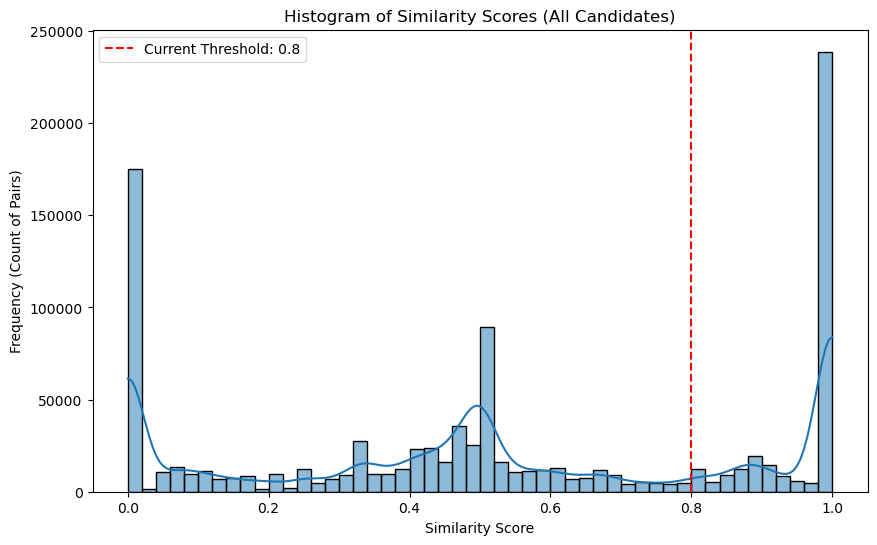

In [37]:
# Create cluster size distribution from our matches
cluster_distribution = EntityMatchingEvaluator.create_cluster_size_distribution(
    correspondences=correspondences,
    out_dir=OUTPUT_DIR / "cluster_analysis"
)

if isinstance(debug_info, pd.DataFrame):
    plt.figure(figsize=(10, 6))
    
    # Use seaborn to plot the histogram of all candidate scores
    # kde=True adds a smooth density line
    sns.histplot(debug_info['similarity'], bins=50, kde=True)
    
    # Add a vertical line to show your chosen threshold
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Current Threshold: {threshold}')
    
    plt.title('Histogram of Similarity Scores (All Candidates)')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency (Count of Pairs)')
    plt.legend()
    plt.show()
else:
    print("debug_info is not a DataFrame. Make sure debug=True was set in matcher.match()")

[INFO ] matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO ] matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


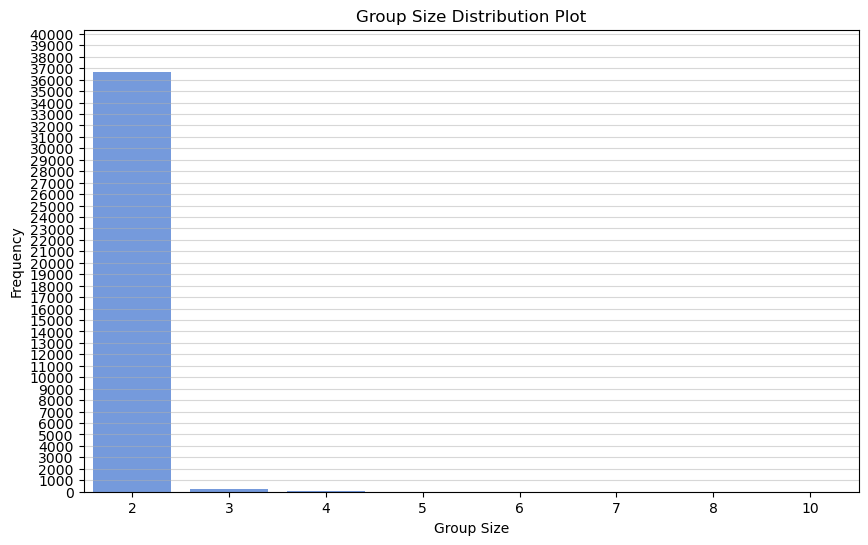

In [30]:
if isinstance(cluster_distribution, pd.DataFrame) and not cluster_distribution.empty:
    
    plt.figure(figsize=(10, 6))
    
    # --- FIX: Change column names from 'Cluster Size' to 'cluster_size' ---
    sns.barplot(
        data=cluster_distribution, 
        x='cluster_size',  # <-- Corrected column name
        y='frequency',   # <-- Corrected column name
        color='cornflowerblue'
    )
    
    # --- FIX: Update 'Frequency' here as well ---
    plt.ylim(0, cluster_distribution['frequency'].max() * 1.1)
    
    # (You may also need to update the tick calculation if max() is 0 or very small)
    max_freq = cluster_distribution['frequency'].max()
    if max_freq > 0:
        # Set y-axis to start at 0 and have integer ticks
        plt.ylim(0, max_freq * 1.1)
        
        # Adjust tick step based on max frequency
        step = max(1, 1000 if max_freq > 5000 else int(max_freq / 5)) # Dynamic step
        plt.yticks(
            ticks=range(0, int(max_freq * 1.1) + 1, step)
        )
    
    # Set labels and title to match the image
    plt.title('Group Size Distribution Plot')
    plt.xlabel('Group Size')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='-', alpha=0.5) 
    
    plt.show()
else:
    print("Cluster distribution data is empty or not in the expected DataFrame format.")

#### The One-to-One Constraint (to deal with the cluster with more than two entity)

PyDI offers the following methods for global matching:

- **GreedyOneToOneMatchingAlgorithm**: Ensures one-to-one matching by greedily selecting highest-scoring correspondences while avoiding conflicts.
- **MaximumBipartiteMatching**: Finds optimal one-to-one matching using maximum weight bipartite matching algorithms.
- **StableMatching**: Finds stable matches where records are matched to mutually preferred partners, ensuring no record would prefer to switch.

In [31]:
from PyDI.entitymatching import GreedyOneToOneMatchingAlgorithm, StableMatching, MaximumBipartiteMatching

one_to_one_algorithm = GreedyOneToOneMatchingAlgorithm()
refined_correspondences = one_to_one_algorithm.cluster(correspondences)

# Create cluster size distribution from our matches
cluster_distribution = EntityMatchingEvaluator.create_cluster_size_distribution(
    correspondences=refined_correspondences,
    out_dir=OUTPUT_DIR / "cluster_analysis"
)

[INFO ] root - Filtered correspondences: 37588 -> 37588 (threshold=0.0)
[INFO ] root - Greedy matching: 37588 -> 37134 correspondences (74268 entities matched)
[INFO ] root - GreedyOneToOneMatchingAlgorithm: 37588 -> 37134 correspondences
[INFO ] root - GreedyOneToOneMatchingAlgorithm: 74577 -> 74268 entities
[INFO ] root - Cluster Size Distribution of 37134 clusters:
[INFO ] root - 	Cluster Size	| Frequency	| Percentage
[INFO ] root - 	──────────────────────────────────────────────────
[INFO ] root - 		2	|	37134	|	100.00%
[INFO ] root - Cluster size distribution written to data\output\cluster_analysis\cluster_size_distribution.csv


#### Run the testing set

In [32]:
eval_results = EntityMatchingEvaluator.evaluate_matching(
    correspondences=refined_correspondences,
    test_pairs=df_test,
    out_dir=debug_output_dir
)

[DEBUG] root - Individual correspondence evaluations:
[DEBUG] root - [correct] left_044547,right_025938,TRUE,sim:0.9867
[DEBUG] root - [correct] left_075781,right_004227,TRUE,sim:0.9785
[DEBUG] root - [correct] left_109216,right_005741,TRUE,sim:0.9681
[DEBUG] root - [correct] left_113655,right_044713,TRUE,sim:0.9675
[DEBUG] root - [correct] left_043774,right_002045,TRUE,sim:0.9663
[DEBUG] root - [correct] left_074936,right_018765,TRUE,sim:0.9639
[DEBUG] root - [correct] left_156878,right_020938,TRUE,sim:0.9633
[DEBUG] root - [correct] left_154185,right_037243,TRUE,sim:0.9621
[DEBUG] root - [correct] left_050085,right_026423,TRUE,sim:0.9593
[DEBUG] root - [correct] left_169219,right_019351,TRUE,sim:0.9592
[DEBUG] root - [correct] left_109762,right_025358,TRUE,sim:0.9588
[DEBUG] root - [correct] left_050461,right_046023,TRUE,sim:0.9583
[DEBUG] root - [correct] left_077729,right_017540,TRUE,sim:0.9582
[DEBUG] root - [correct] left_110956,right_015270,TRUE,sim:0.9572
[DEBUG] root - [correc

#### other combination of rule-based methods:

[INFO ] PyDI.entitymatching.rule_based.RuleBasedMatcher - Starting Entity Matching
[INFO ] PyDI.entitymatching.rule_based.RuleBasedMatcher - Blocking 189345 x 69441 elements
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Creating candidate record pairs from 36663 blocks


Starting matching process...


[INFO ] PyDI.entitymatching.rule_based.RuleBasedMatcher - Matching 189345 x 69441 elements after 0:00:0.206; 144847 blocked pairs (reduction ratio: 0.999988983599986)
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Creating candidate record pairs from 36663 blocks
[INFO ] PyDI.entitymatching.rule_based.RuleBasedMatcher - Entity Matching finished after 0:00:192.010; found 35004 correspondences.


Matching completed.
Runtime: 192.6647 seconds
Found 35004 matches.


[DEBUG] root - Individual correspondence evaluations:
[DEBUG] root - [wrong] left_010604,right_033702,FALSE,sim:0.7353
[DEBUG] root - [correct] left_178347,right_024944,TRUE,sim:1.0000
[DEBUG] root - [correct] left_000318,right_063410,TRUE,sim:1.0000
[DEBUG] root - [correct] left_000406,right_032678,TRUE,sim:0.8500
[DEBUG] root - [wrong] left_002851,right_057124,FALSE,sim:0.8000
[DEBUG] root - [correct] left_006918,right_052126,TRUE,sim:1.0000
[DEBUG] root - [correct] left_171680,right_020430,TRUE,sim:1.0000
[DEBUG] root - [correct] left_007504,right_018561,TRUE,sim:1.0000
[DEBUG] root - [wrong] left_018854,right_031548,FALSE,sim:1.0000
[DEBUG] root - [correct] left_109908,right_036875,TRUE,sim:1.0000
[DEBUG] root - [correct] left_168306,right_005395,TRUE,sim:0.7750
[DEBUG] root - [correct] left_044776,right_041671,TRUE,sim:1.0000
[DEBUG] root - [correct] left_045621,right_014233,TRUE,sim:1.0000
[DEBUG] root - [correct] left_046723,right_016534,TRUE,sim:1.0000
[DEBUG] root - [correct] 

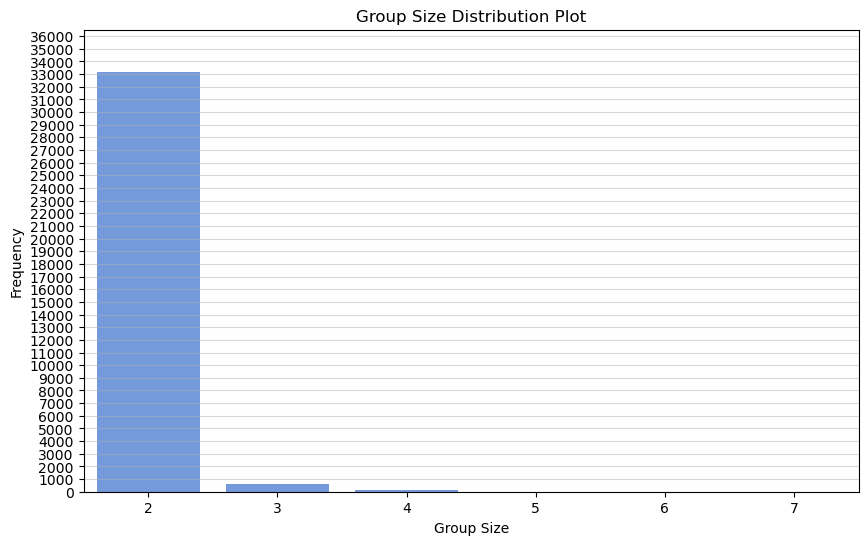

[INFO ] root - Filtered correspondences: 35004 -> 35004 (threshold=0.0)
[INFO ] root - Greedy matching: 35004 -> 34111 correspondences (68222 entities matched)
[INFO ] root - GreedyOneToOneMatchingAlgorithm: 35004 -> 34111 correspondences
[INFO ] root - GreedyOneToOneMatchingAlgorithm: 68890 -> 68222 entities
[INFO ] root - Cluster Size Distribution of 34111 clusters:
[INFO ] root - 	Cluster Size	| Frequency	| Percentage
[INFO ] root - 	──────────────────────────────────────────────────
[INFO ] root - 		2	|	34111	|	100.00%
[INFO ] root - Cluster size distribution written to data\output\cluster_analysis\cluster_size_distribution.csv


[INFO ] root - Filtered correspondences: 117466 -> 117466 (threshold=0.0)
[INFO ] root - Greedy matching: 117466 -> 43407 correspondences (86814 entities matched)
[INFO ] root - GreedyOneToOneMatchingAlgorithm: 117466 -> 43407 correspondences
[INFO ] root - GreedyOneToOneMatchingAlgorithm: 104076 -> 86814 entities
[INFO ] PyDI.entitymatching.evaluation - Cluster Size Distribution of 43407 clusters:
[INFO ] PyDI.entitymatching.evaluation - 	Cluster Size	| Frequency	| Percentage
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Eirik Solberg\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 1154, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Eirik Solberg\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncod

In [43]:

def normalize_foot(text):
    """
    Normalizes foot descriptions to ensure 'either', 'both', and 'left and right'
    are treated effectively as the same concept containing both 'left' and 'right' tokens.
    """
    if pd.isna(text):
        return ""
    t = str(text).lower()
    # Map all variations of "both feet" to a standard string containing both tokens
    if t in ['either', 'both', 'left and right', 'left & right']:
        return "left right" 
    return t

def normalize_position(text):
    """
    Cleans position strings to improve character-based overlap.
    Removes parentheses and commas. e.g., "AM (R)" -> "am r"
    """
    if pd.isna(text):
        return ""
    # Remove punctuation and lowercase
    t = str(text).lower().replace('(', '').replace(')', '').replace(',', '')
    return t

comparators = [
    # Rule 1: player_name
    # Using Levenshtein is robust for typos in names (e.g., "Ronaldo" vs "Ronalldo").
    StringComparator(
        column="player_name",
        similarity_function="levenshtein",
        preprocess=str.lower  # Normalize to lowercase
    ),
    
    
    # Rule 5: date_of_birth
    # Calculates similarity based on the number of days difference.
    # tolerance=365 means if dates are within 1 year, similarity > 0.
    DateComparator(
        column="date_of_birth", 
        max_days_difference=365  #  1 year 
    ),

    # Rule 6: height_cm
    # Using relative difference or absolute difference for numbers.
    NumericComparator(
        column="height_cm",
        method="absolute_difference",
    )
]

# --- 2. Define the weights for the comparators ---
# Weights determine the importance of each rule. 
# Total sum does not have to be 1.0, but it helps for readability.
# Order: Name, Nation, Position, Club, DOB, Height, Foot
weights = [0.5,  0.2, 0.3]

# --- 3. Define the similarity threshold ---
# Only pairs with a weighted average score above this will be returned.
threshold = 0.72

# --- 4. Execution ---

# Initialize matcher
matcher = RuleBasedMatcher()

print("Starting matching process...")
start_time = time.time()

correspondences, debug_info = matcher.match(
    df_left=df_FM,                  
    df_right=df_TM,                  
    candidates=blocker_standard2,        
    id_column='pydi_id',              
    comparators=comparators,         # The list of comparators defined above
    weights=weights,                 # The list of weights defined above
    threshold=threshold,
    debug=True                       # Returns detailed scoring info
)

end_time = time.time()

print(f"Matching completed.")
print(f"Runtime: {end_time - start_time:.4f} seconds")
print(f"Found {len(correspondences)} matches.")


# 2.
debug_output_dir = OUTPUT_DIR / "debug_results_entity_matching"
debug_output_dir.mkdir(parents=True, exist_ok=True)

eval_results = EntityMatchingEvaluator.evaluate_matching(
    correspondences=correspondences,
    test_pairs=df_validation,
    out_dir=debug_output_dir,
    # debug_info=debug_info, # add debug info
    # matcher_instance=matcher # add matcher instance for context for debug files 
)

# 3. cluster analysis
# Create cluster size distribution from our matches
cluster_distribution = EntityMatchingEvaluator.create_cluster_size_distribution(
    correspondences=correspondences,
    out_dir=OUTPUT_DIR / "cluster_analysis"
)
if isinstance(cluster_distribution, pd.DataFrame) and not cluster_distribution.empty:
    
    plt.figure(figsize=(10, 6))
    
    # --- FIX: Change column names from 'Cluster Size' to 'cluster_size' ---
    sns.barplot(
        data=cluster_distribution, 
        x='cluster_size',  # <-- Corrected column name
        y='frequency',   # <-- Corrected column name
        color='cornflowerblue'
    )
    
    # --- FIX: Update 'Frequency' here as well ---
    plt.ylim(0, cluster_distribution['frequency'].max() * 1.1)
    
    # (You may also need to update the tick calculation if max() is 0 or very small)
    max_freq = cluster_distribution['frequency'].max()
    if max_freq > 0:
        # Set y-axis to start at 0 and have integer ticks
        plt.ylim(0, max_freq * 1.1)
        
        # Adjust tick step based on max frequency
        step = max(1, 1000 if max_freq > 5000 else int(max_freq / 5)) # Dynamic step
        plt.yticks(
            ticks=range(0, int(max_freq * 1.1) + 1, step)
        )
    
    # Set labels and title to match the image
    plt.title('Group Size Distribution Plot')
    plt.xlabel('Group Size')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='-', alpha=0.5) 
    
    plt.show()
else:
    print("Cluster distribution data is empty or not in the expected DataFrame format.")

# 4.
one_to_one_algorithm = GreedyOneToOneMatchingAlgorithm()
refined_correspondences = one_to_one_algorithm.cluster(correspondences)

# Create cluster size distribution from our matches
cluster_distribution = EntityMatchingEvaluator.create_cluster_size_distribution(
    correspondences=refined_correspondences,
    out_dir=OUTPUT_DIR / "cluster_analysis"
)

## 6. Blocking(Birthday+one word overlapping) + ML model

For use with e.g. scikit-learn classifiers. Comparators are the features. Train on labeled pairs to learn optimal weights.

Feature extraction converts record pairs into feature vectors using the set of comparators. The FeatureExtractor class handles this transformation.

In [56]:

# df_left = df_FM
# df_right = df_TM

def normalize_foot(text):
    if pd.isna(text):
        return ""
    t = str(text).lower()
    if t in ['either', 'both', 'left and right', 'left & right']:
        return "left right" 
    return t

def normalize_position(text):
    if pd.isna(text):
        return ""
    t = str(text).lower().replace('(', '').replace(')', '').replace(',', '')
    return t

# --- 2. Define Feature Extractors (Comparators) ---
comparators = [
    # Feature 1: player_name similarity
    StringComparator(
        column="player_name",
        similarity_function="levenshtein",
        preprocess=str.lower
    ),
    
    # Feature 2: nationality similarity
    StringComparator(
        column="nationality",
        similarity_function="jaro_winkler",
        preprocess=str.lower
    ),
    
    # Feature 3: positions_position overlap
    StringComparator(
        column="positions_position",
        similarity_function="overlap", 
        tokenization='char',
        preprocess=normalize_position
    ),
    
    # Feature 4: clubs_club similarity
    StringComparator(
        column="clubs_club",
        similarity_function="jaro_winkler",
        preprocess=str.lower
    ),

    # Feature 5: date_of_birth similarity
    DateComparator(
        column="date_of_birth", 
         max_days_difference=365,
    ),

    # Feature 6: height_cm similarity
    # 同樣設定 tolerance 將差異標準化
    NumericComparator(
        column="height_cm",
        method="absolute_difference",
    ),

    # Feature 7: left_right_foot similarity
    StringComparator(
        column="left_right_foot",
        similarity_function="jaccard",
        tokenization="word",
        preprocess=normalize_foot
    )
]


extractor = FeatureExtractor(comparators)

# --- 3. Extract Features for Training Data ---
print("Extracting features for Training set...")
train_features_df = extractor.create_features(
    df_left=df_FM, 
    df_right=df_TM, 
    pairs=df_train[['id1', 'id2']], labels=df_train['label'], id_column='pydi_id'
)

train_features_df['label'] = df_train['label'].values

train_features_df = train_features_df.fillna(0)

feature_columns = [col for col in train_features_df.columns if col not in ['id1', 'id2', 'label', 'pair_id']]
print(f"Features used: {feature_columns}")

X_train = train_features_df[feature_columns]
y_train = train_features_df['label'].astype(int) 

# --- 4. Train the Model ---
print("Training RandomForest Classifier...")
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# --- 5. Evaluate on val Set (Optional but Recommended) ---
print("\nEvaluating on val set...")
val_features_df = extractor.create_features(
    df_left=df_FM, 
    df_right=df_TM, 
    pairs=df_validation[['id1', 'id2']],
    id_column='pydi_id'
)
val_features_df = val_features_df.fillna(0)
X_val = val_features_df[feature_columns]
y_val = df_validation['label'].astype(int)

y_pred = clf.predict(X_val)

print("\nClassification Report (val Set):")
print(classification_report(y_val, y_pred))

Extracting features for Training set...


[INFO ] root - Label distribution: 58 positive, 134 negative


Features used: ['StringComparator(player_name, levenshtein, tokenization=char, list_strategy=None)', 'StringComparator(nationality, jaro_winkler, tokenization=char, list_strategy=None)', 'StringComparator(positions_position, overlap, tokenization=char, list_strategy=None)', 'StringComparator(clubs_club, jaro_winkler, tokenization=char, list_strategy=None)', 'DateComparator(date_of_birth, list_strategy=None)', 'NumericComparator(height_cm, absolute_difference, list_strategy=None)', 'StringComparator(left_right_foot, jaccard, tokenization=word, list_strategy=None)']
Training RandomForest Classifier...

Evaluating on val set...

Classification Report (val Set):
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       100
           1       0.84      0.84      0.84        44

    accuracy                           0.90       144
   macro avg       0.89      0.89      0.89       144
weighted avg       0.90      0.90      0.90       144



[DEBUG] matplotlib.font_manager - findfont: Matching sans\-serif:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0.
[DEBUG] matplotlib.font_manager - findfont: score(FontEntry(fname='C:\\Users\\User\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
[DEBUG] matplotlib.font_manager - findfont: score(FontEntry(fname='C:\\Users\\User\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
[DEBUG] matplotlib.font_manager - findfont: score(FontEntry(fname='C:\\Users\\User\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
[DEBUG] matplotlib.font_manager


Feature Ranking:
1. DateComparator(date_of_birth, list_strategy=None) (0.3117)
2. NumericComparator(height_cm, absolute_difference, list_strategy=None) (0.1914)
3. StringComparator(player_name, levenshtein, tokenization=char, list_strategy=None) (0.1717)
4. StringComparator(positions_position, overlap, tokenization=char, list_strategy=None) (0.1419)
5. StringComparator(nationality, jaro_winkler, tokenization=char, list_strategy=None) (0.0949)
6. StringComparator(clubs_club, jaro_winkler, tokenization=char, list_strategy=None) (0.0691)
7. StringComparator(left_right_foot, jaccard, tokenization=word, list_strategy=None) (0.0193)


[DEBUG] matplotlib.font_manager - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\taile.ttf', name='Microsoft Tai Le', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
[DEBUG] matplotlib.font_manager - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MTEXTRA.TTF', name='MT Extra', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
[DEBUG] matplotlib.font_manager - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALISTB.TTF', name='Calisto MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
[DEBUG] matplotlib.font_manager - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\wp310-05.ttf', name='HanWangMingMediumPoIn3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
[DEBUG] matplotlib.font_manager - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LSANSI.TTF', name='Lucida Sans', style='italic', varian

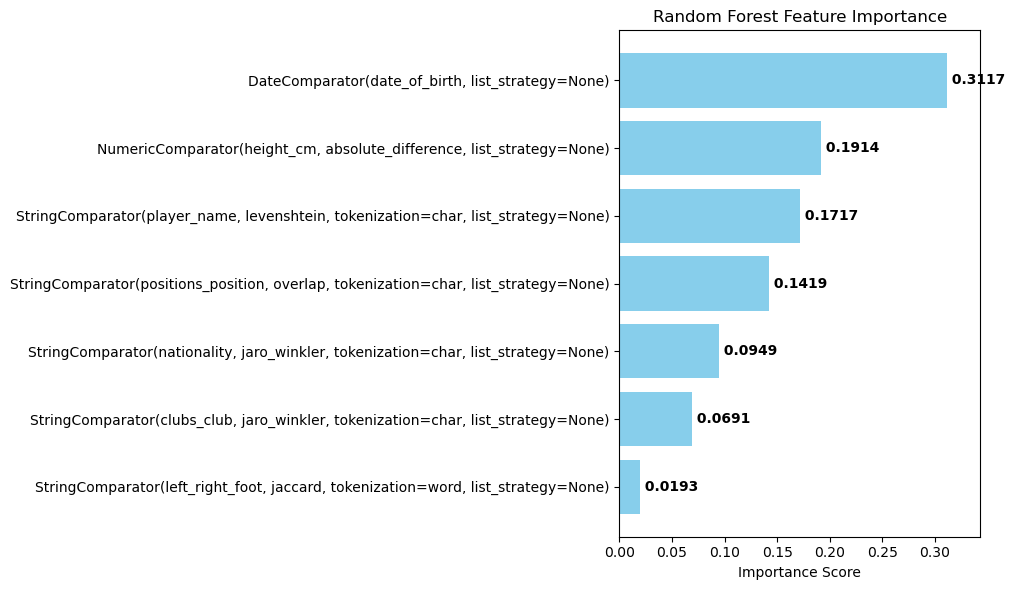

In [54]:

# --- 6. Feature Importance Analysis ---

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nFeature Ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. {feature_columns[indices[f]]} ({importances[indices[f]]:.4f})")

# --- Feature Importance Visualization ---

# 1. Prepare the data
# Get feature importances from the trained classifier
importances = clf.feature_importances_

# Sort indices in descending order (Highest importance first)
indices = np.argsort(importances)[::-1]

# Create sorted lists for labels and values
# We simply map the sorted indices to the original feature_columns list
sorted_labels = [feature_columns[i] for i in indices]
sorted_values = importances[indices]

# 2. Setup the plot
# Set a larger figure size to ensure long labels fit
plt.figure(figsize=(10, 6))

# 3. Create a Horizontal Bar Chart
# Note: We slice with [::-1] to reverse the order for plotting.
# This ensures the "Most Important" feature appears at the TOP of the Y-axis.
bars = plt.barh(range(len(indices)), sorted_values[::-1], color='skyblue', align='center')

# 4. Configure axis labels and title
# Set the y-ticks to match the feature names (also reversed)
plt.yticks(range(len(indices)), sorted_labels[::-1])
plt.xlabel("Importance Score")
plt.title("Random Forest Feature Importance")

# 5. Add value annotations to the bars
# This loop places the exact numeric score next to each bar
for i, v in enumerate(sorted_values[::-1]):
    # Place text slightly to the right of the bar end
    plt.text(v, i, f" {v:.4f}", va='center', fontweight='bold')

# 6. Adjust layout and display
plt.xlim(0, max(sorted_values) * 1.1) # Add some space on the right for text
plt.tight_layout() # Automatically adjusts margins to prevent clipping
plt.show()

#### output all the correspondence

[INFO ] PyDI.entitymatching.ml_based.MLBasedMatcher - Starting Entity Matching
[INFO ] PyDI.entitymatching.ml_based.MLBasedMatcher - Blocking 189345 x 69441 elements
[DEBUG] PyDI.entitymatching.blocking.standard.StandardBlocker - Creating candidate record pairs from 16315 blocks


Starting matching process...


[INFO ] PyDI.entitymatching.ml_based.MLBasedMatcher - Matching 189345 x 69441 elements after 0:00:0.577; 2576111 blocked pairs (reduction ratio: 0.999804072785377)
[INFO ] PyDI.entitymatching.ml_based.MLBasedMatcher - Entity Matching finished after 0:00:3850.111; found 32578 correspondences.


Matching completed.
Runtime: 3850.1644 seconds
Found 32578 matches.


[DEBUG] root - Individual correspondence evaluations:
[DEBUG] root - [correct] left_171680,right_020430,TRUE,sim:1.0000
[DEBUG] root - [correct] left_006918,right_052126,TRUE,sim:1.0000
[DEBUG] root - [correct] left_007504,right_018561,TRUE,sim:1.0000
[DEBUG] root - [correct] left_178347,right_024944,TRUE,sim:1.0000
[DEBUG] root - [correct] left_000318,right_063410,TRUE,sim:1.0000
[DEBUG] root - [correct] left_169385,right_058215,TRUE,sim:1.0000
[DEBUG] root - [correct] left_000406,right_032678,TRUE,sim:1.0000
[DEBUG] root - [correct] left_175716,right_054264,TRUE,sim:1.0000
[DEBUG] root - [correct] left_073892,right_013266,TRUE,sim:1.0000
[DEBUG] root - [correct] left_046723,right_016534,TRUE,sim:1.0000
[DEBUG] root - [wrong] left_152262,right_067428,FALSE,sim:1.0000
[DEBUG] root - [wrong] left_002851,right_057124,FALSE,sim:1.0000
[DEBUG] root - [correct] left_079927,right_038494,TRUE,sim:1.0000
[DEBUG] root - [correct] left_105834,right_015079,TRUE,sim:1.0000
[DEBUG] root - [wrong] l

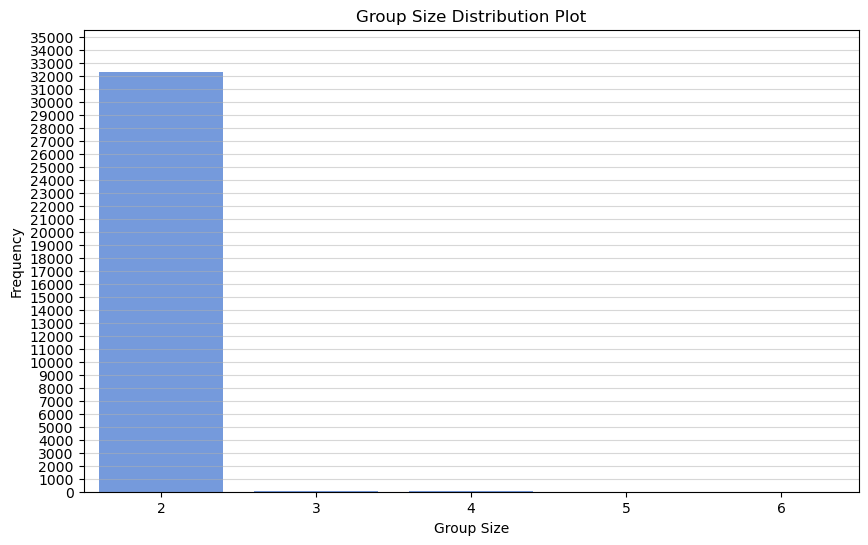

[INFO ] root - Filtered correspondences: 32578 -> 32578 (threshold=0.0)
[INFO ] root - Greedy matching: 32578 -> 32443 correspondences (64886 entities matched)
[INFO ] root - GreedyOneToOneMatchingAlgorithm: 32578 -> 32443 correspondences
[INFO ] root - GreedyOneToOneMatchingAlgorithm: 64985 -> 64886 entities
[INFO ] root - Cluster Size Distribution of 32443 clusters:
[INFO ] root - 	Cluster Size	| Frequency	| Percentage
[INFO ] root - 	──────────────────────────────────────────────────
[INFO ] root - 		2	|	32443	|	100.00%
[INFO ] root - Cluster size distribution written to data\output\cluster_analysis\cluster_size_distribution.csv


In [59]:
# --- 4. Execution ---
# Initialize matcher

matcher = MLBasedMatcher(extractor)

print("Starting matching process...")

start_time = time.time()

correspondences= matcher.match(
    df_left=df_FM,                  
    df_right=df_TM,                  
    candidates=blocker_standard,        
    id_column='pydi_id',              
    trained_classifier=clf
)

end_time = time.time()

print(f"Matching completed.")
print(f"Runtime: {end_time - start_time:.4f} seconds")
print(f"Found {len(correspondences)} matches.")


# 2.
debug_output_dir = OUTPUT_DIR / "debug_results_entity_matching"
debug_output_dir.mkdir(parents=True, exist_ok=True)

eval_results = EntityMatchingEvaluator.evaluate_matching(
    correspondences=correspondences,
    test_pairs=df_validation,
    out_dir=debug_output_dir,
    # debug_info=debug_info, # add debug info
    # matcher_instance=matcher # add matcher instance for context for debug files 
)

# 3. cluster analysis
# Create cluster size distribution from our matches
cluster_distribution = EntityMatchingEvaluator.create_cluster_size_distribution(
    correspondences=correspondences,
    out_dir=OUTPUT_DIR / "cluster_analysis"
)
if isinstance(cluster_distribution, pd.DataFrame) and not cluster_distribution.empty:
    
    plt.figure(figsize=(10, 6))
    
    # --- FIX: Change column names from 'Cluster Size' to 'cluster_size' ---
    sns.barplot(
        data=cluster_distribution, 
        x='cluster_size',  # <-- Corrected column name
        y='frequency',   # <-- Corrected column name
        color='cornflowerblue'
    )
    
    # --- FIX: Update 'Frequency' here as well ---
    plt.ylim(0, cluster_distribution['frequency'].max() * 1.1)
    
    # (You may also need to update the tick calculation if max() is 0 or very small)
    max_freq = cluster_distribution['frequency'].max()
    if max_freq > 0:
        # Set y-axis to start at 0 and have integer ticks
        plt.ylim(0, max_freq * 1.1)
        
        # Adjust tick step based on max frequency
        step = max(1, 1000 if max_freq > 5000 else int(max_freq / 5)) # Dynamic step
        plt.yticks(
            ticks=range(0, int(max_freq * 1.1) + 1, step)
        )
    
    # Set labels and title to match the image
    plt.title('Group Size Distribution Plot')
    plt.xlabel('Group Size')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='-', alpha=0.5) 
    
    plt.show()
else:
    print("Cluster distribution data is empty or not in the expected DataFrame format.")

# 4.
one_to_one_algorithm = GreedyOneToOneMatchingAlgorithm()
refined_correspondences = one_to_one_algorithm.cluster(correspondences)

# Create cluster size distribution from our matches
cluster_distribution = EntityMatchingEvaluator.create_cluster_size_distribution(
    correspondences=refined_correspondences,
    out_dir=OUTPUT_DIR / "cluster_analysis"
)

## 6. Save the finalized file for Data Fusion

In [33]:
correspondences_output_dir = OUTPUT_DIR / "correspondences"
correspondences_output_dir.mkdir(parents=True, exist_ok=True)

refined_correspondences.to_pickle(f"{OUTPUT_DIR}/correspondences/refined_correspondences_FM&TM.pkl") # remember to change the file name

refined_correspondences.to_csv(f"{OUTPUT_DIR}/correspondences/refined_correspondences_FM&TM.csv", index=False)